Run on NERSC

In [6]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
from astropy.io import fits

In [7]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [8]:
def plot_cutout(img, pixscale, vmin=-1, vmax=1, unit='arcsec'):
    if unit=='arcsec':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])
    elif unit=='arcmin':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])/60.
    elif unit=='deg':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])/3600.
    else:
        raise ValueError('unrecognized unit')
    fig, ax = plt.subplots(figsize=(8, 8))
    dens = ax.imshow(img, aspect='equal', 
               cmap='seismic', extent=extent, vmin=vmin, vmax=vmax)
    ax.axvline(0, ls='--', lw=0.5, color='grey')
    ax.axhline(0, ls='--', lw=0.5, color='grey')
    fig.colorbar(dens, fraction=0.046, pad=0.04)
    ax.grid(alpha=0.5)
    return ax

In [9]:
band = 'g'
field = 'south'
region_name = 'decals_ngc'

radius_lim1, radius_lim2 = 4.5, 5.5
radius_lim3, radius_lim4 = 6., 6.8

In [10]:
ccd = fitsio.read('/global/project/projectdirs/cosmo/work/legacysurvey/dr9/reorg/survey-ccds-decam-dr9-newlocs2.fits.gz')
ccd = Table(ccd)
print(len(ccd))

# Load Schlegel's CCD file list
fn = '/global/project/projectdirs/cosmo/work/users/djschleg/dr9lists/dr9c.txt'
with open(fn, 'r') as f:
    lines = list(map(str.rstrip, f.readlines()))
print(len(lines))
# print(lines[0])

ccd['basename'] = list(map(os.path.basename, ccd['image_filename']))
mask = np.in1d(ccd['basename'], np.array(lines))
print(np.sum(mask)/len(mask))
ccd = ccd[mask]
print(len(ccd))

ccd_mask = ccd['filter']==band
print(np.sum(ccd_mask))

expnum_all = np.sort(np.unique(ccd[ccd_mask]['expnum']))
print(len(expnum_all))

3560028
2191
0.0371909996214
132401
44512
735


In [11]:
if (field=='north') and ((band=='g') or (band=='r')):
    pixscale_native = 0.454
else:
    pixscale_native = 0.262
# pixscale = 0.262 # pixscale for cutout queries

tmp = np.loadtxt('../data/{}_poly_fit.txt'.format(region_name))
band_index = np.where(band==np.array(['g', 'r', 'z']))[0][0]
poly = np.poly1d(tmp[band_index])
print(poly)
profile_fit = np.poly1d(poly)

         5          4         3         2
-0.2537 x + 0.2668 x + 1.461 x - 1.998 x - 3.398 x - 2.236


__Check that the fit works__

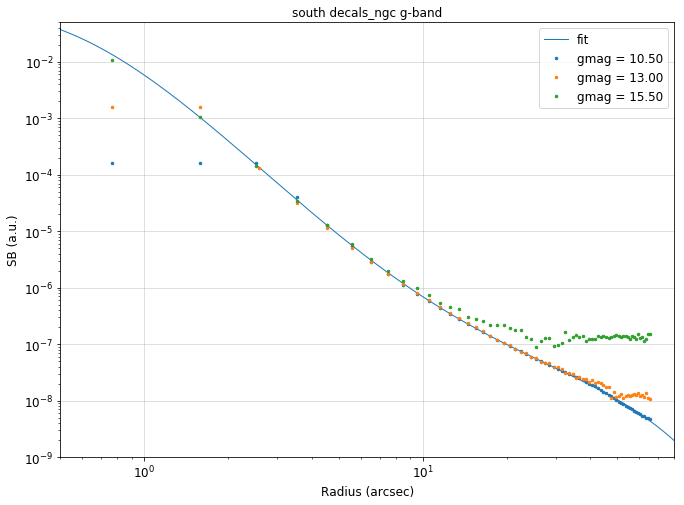

In [12]:
ls_mag_bins = [10.5, 11.75, 13.0, 14.25, 15.5]

profile = Table.read('../data/average_profiles_{}_{}_{}.txt'.format(field, region_name, band), format='ascii.commented_header')
indiv = Table.read('../data/individual_profiles_{}_{}_{}.fits'.format(field, region_name, band))

xfit = np.logspace(-1, 2, 200)
yfit = 10**(profile_fit(np.log10(xfit)))

plt.figure(figsize=(11, 8))
plt.loglog(xfit, yfit, '-', lw=1., alpha=1., 
           label='fit', c='C0')
# for index in range(len(ls_mag_bins)):
for index in [0, 2, 4]:
    # normalize the flux to 22.5 magnitude stars
    norm = 10**((ls_mag_bins[index]-22.5)/2.5) * pixscale_native**2
    x = profile['radius_{}_{:.2f}'.format(band, ls_mag_bins[index])]
    y = norm * profile['flux_{}_{:.2f}'.format(band, ls_mag_bins[index])]
    plt.loglog(x, y, '.', lw=1.2, alpha=1., ms=5.,
               label='{}mag = {:.2f}'.format(band, ls_mag_bins[index]))
plt.title('{} {} {}-band'.format(field, region_name, band))
plt.axis([0.5, 80, 1e-9, 5e-2])
plt.grid(alpha=0.5)
plt.xlabel('Radius (arcsec)')
plt.ylabel('SB (a.u.)')
plt.legend()
plt.show()

In [13]:
output_dir = '/global/cscratch1/sd/rongpu/temp/decam-psfex-merged'

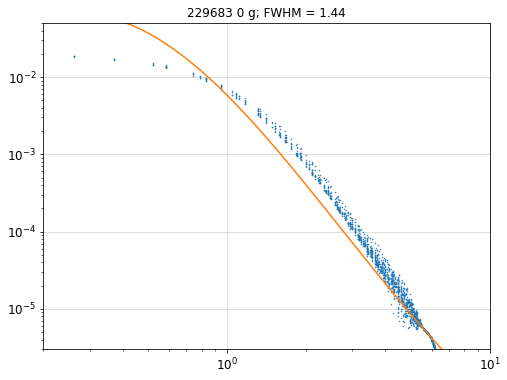

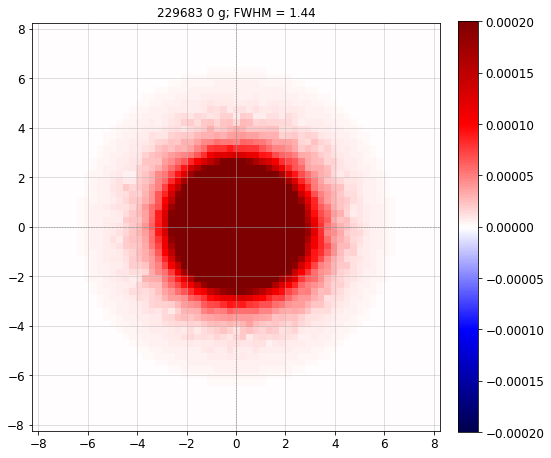

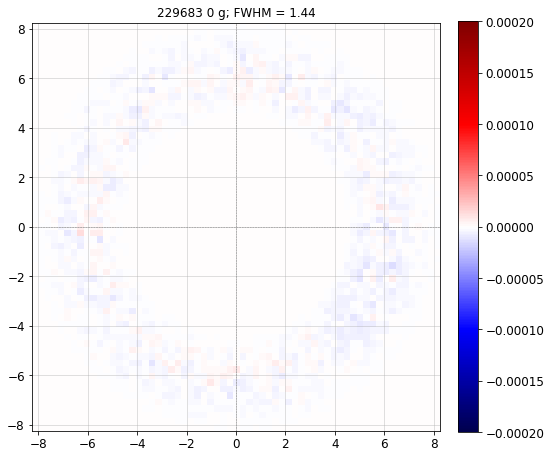

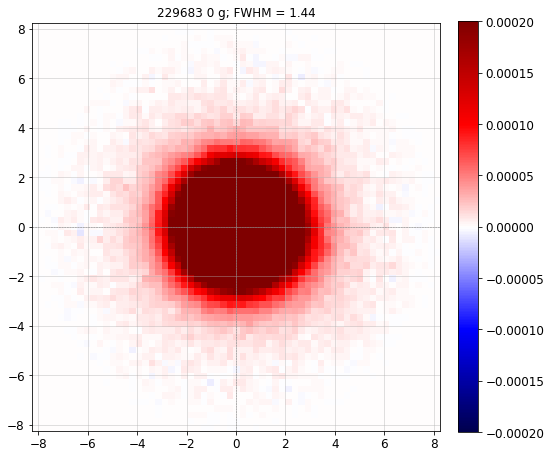

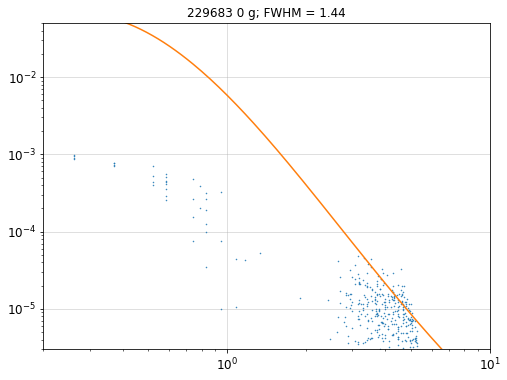

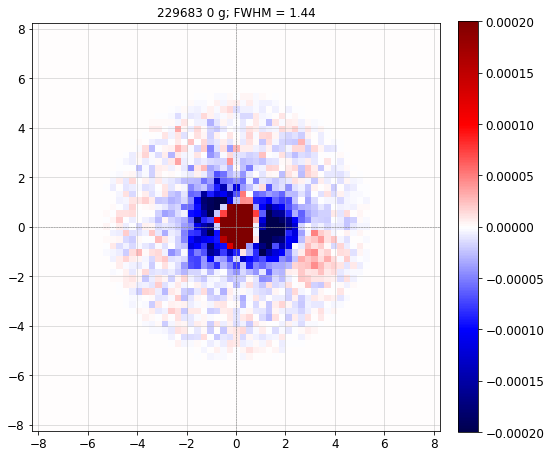

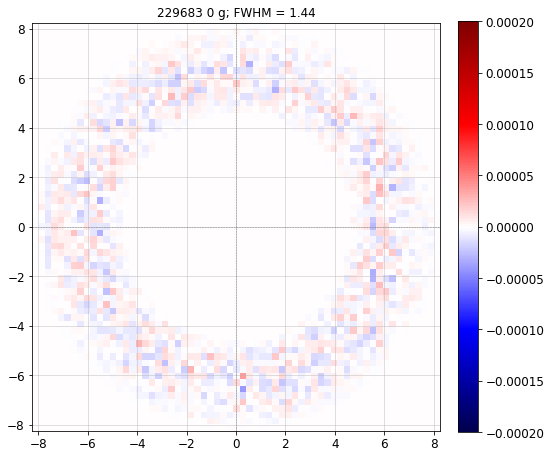

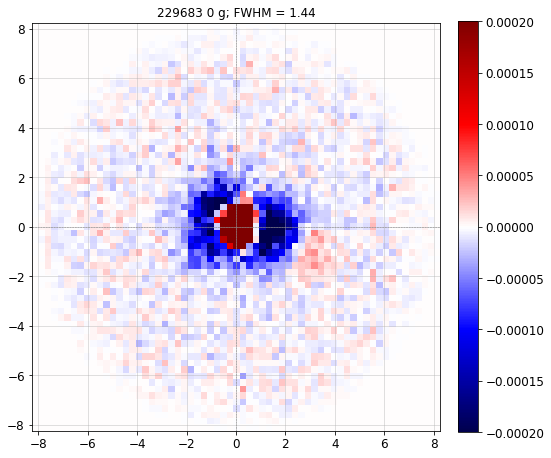

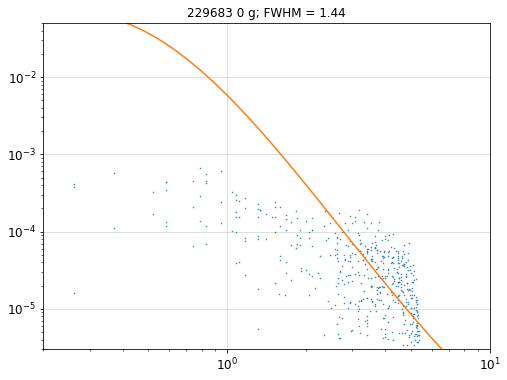

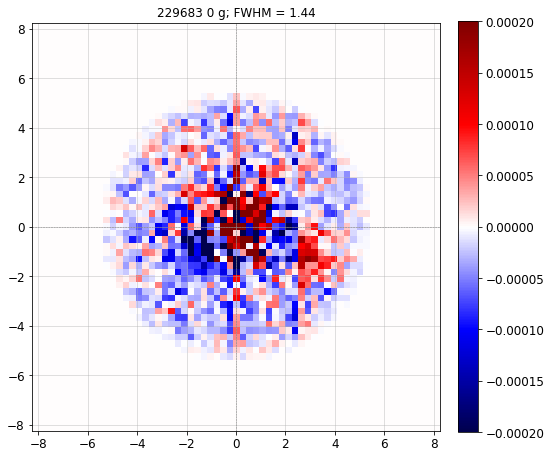

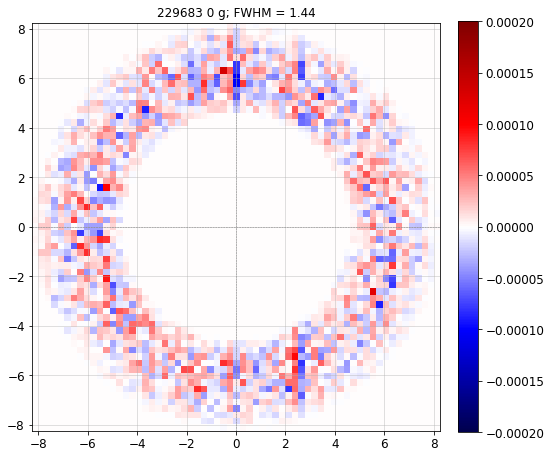

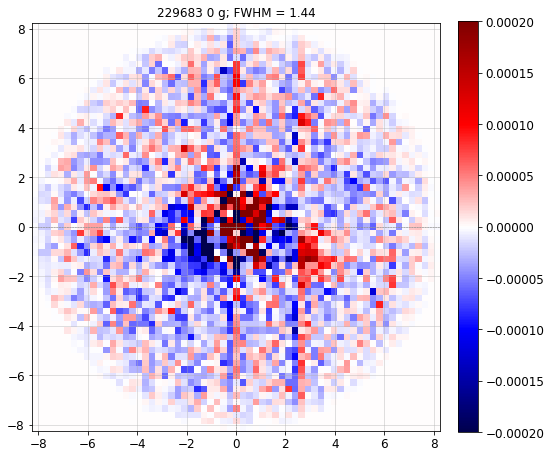

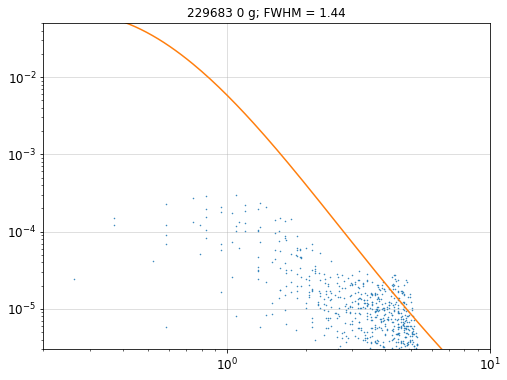

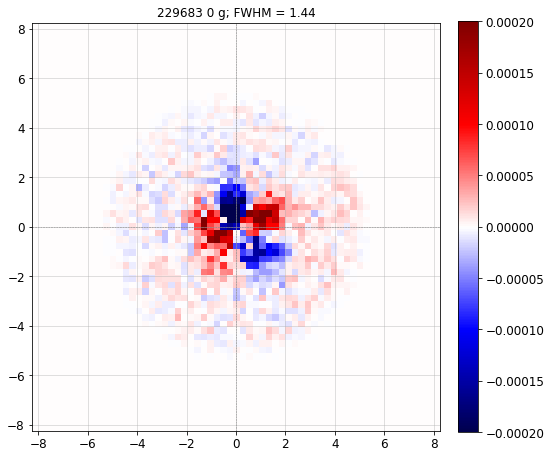

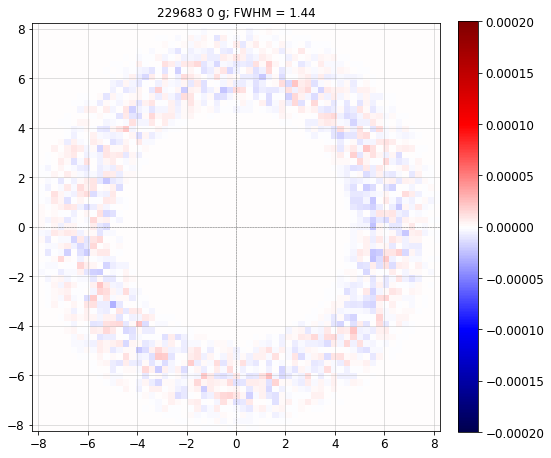

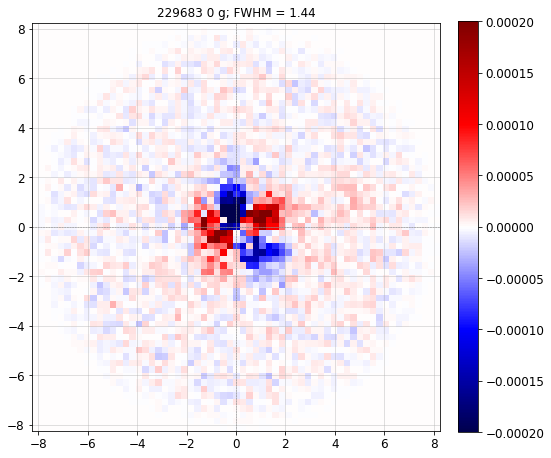

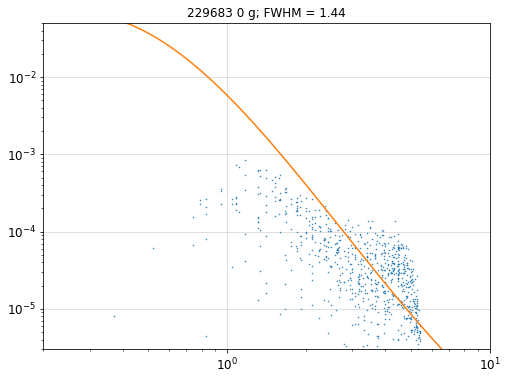

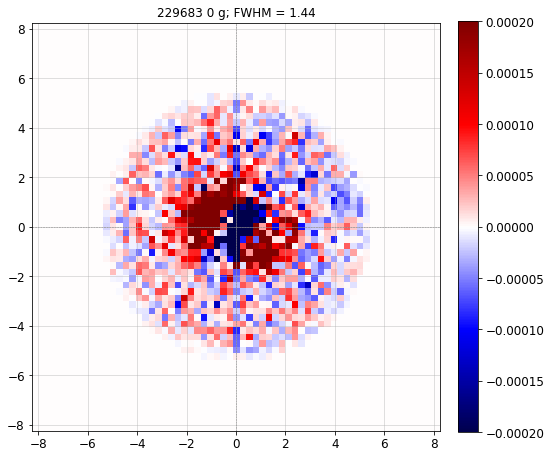

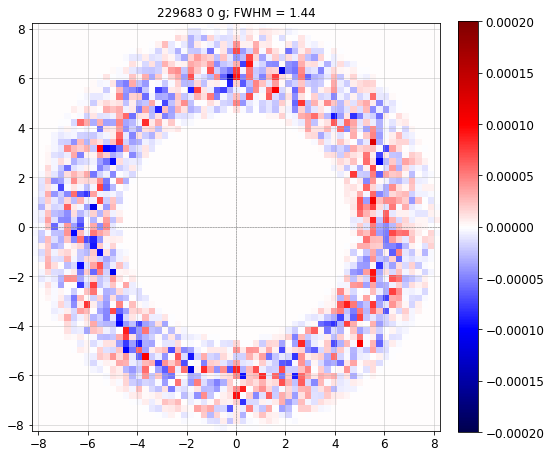

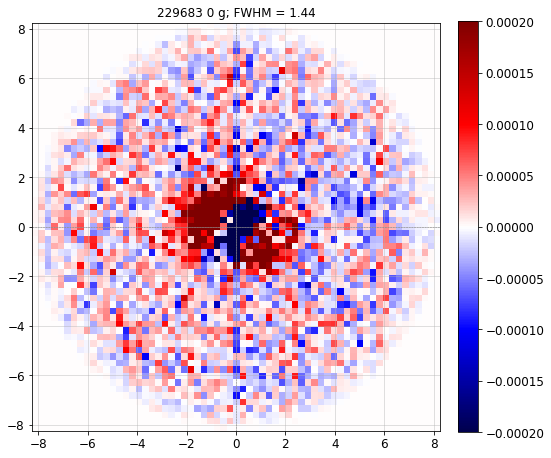

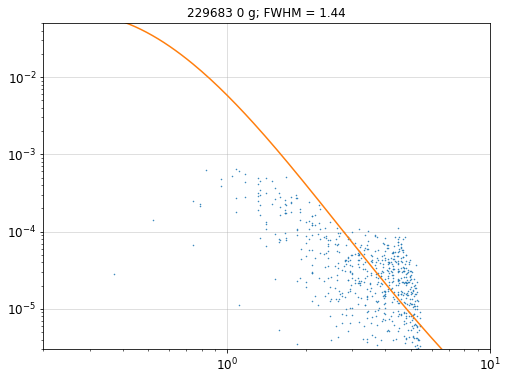

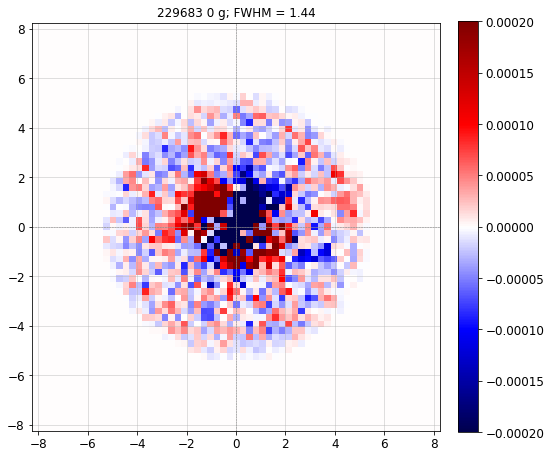

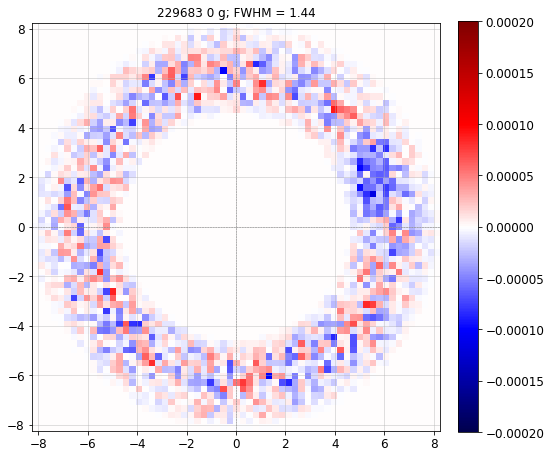

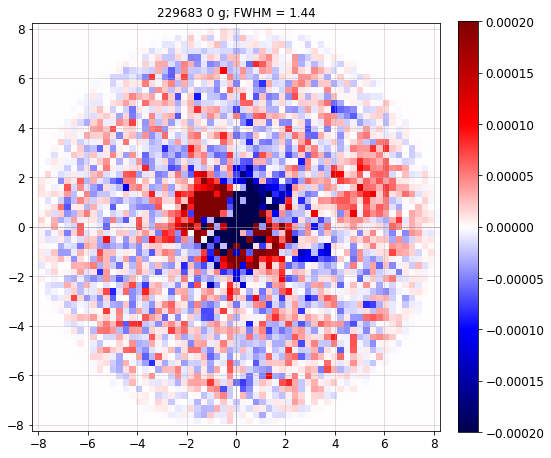

In [15]:
# for index, expnum in enumerate(expnum_all):
for index, expnum in enumerate(expnum_all[:1]):
    
    expnum_str = str(expnum)

    fn = '/global/project/projectdirs/cosmo/work/legacysurvey/dr9/calib/decam/psfex-merged/{}/decam-{}.fits'.format((5-len(expnum_str[:3]))*'0'+expnum_str[:3], (8-len(expnum_str))*'0'+expnum_str)
    
    hdu = fits.open(fn)
    data = hdu[1].data
    # print(data['psf_mask'].shape)

    ##############################
    ccd_index = 0
    ##############################
        
    psf_all = data['psf_mask'][ccd_index]
    # print(psf_all.shape)

    # psf_index = 0
    for psf_index in range(len(psf_all)):
        
        psfi = psf_all[psf_index]

        if psf_index==0:
            # normalize to a 22.5 magnitude star
            # print(np.sum(psfi))
            psfi = psfi/np.sum(psfi)

            grid = pixscale_native * np.linspace(-0.5*(psfi.shape[0]-1), 0.5*(psfi.shape[0]-1), psfi.shape[0])
            xx, yy = np.meshgrid(grid, grid)
            radius_grid = np.sqrt(xx**2 + yy**2)
            radius = radius_grid.flatten()

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                img_fit = 10**(profile_fit(np.log10(radius_grid)))
                img_fit[~np.isfinite(img_fit)] = 0

            psfi_combine = psfi.copy()

            r1, r2 = radius_lim1, radius_lim2
            mask = (radius_grid>r1) & (radius_grid<r2)
            psfi_combine[mask] = psfi[mask] * (r2-radius_grid[mask])/(r2-r1) \
                           + img_fit[mask] * (radius_grid[mask]-r1)/(r2-r1)

            r1, r2 = radius_lim2, radius_lim3
            mask = (radius_grid>=r1) & (radius_grid<r2)
            psfi_combine[mask] = img_fit[mask]

            r1, r2 = radius_lim3, radius_lim4
            mask = (radius_grid>=r1) & (radius_grid<r2)
            psfi_combine[mask] = img_fit[mask] * (r2-radius_grid[mask])/(r2-r1) \
                           + 0 * (radius_grid[mask]-r1)/(r2-r1)

            mask = (radius_grid>radius_lim4)
            psfi_combine[mask] = 0
        
        else:
            
            psfi_combine = psfi.copy()

            r1, r2 = radius_lim1, radius_lim2
            mask = (radius_grid>r1) & (radius_grid<r2)
            psfi_combine[mask] = psfi[mask] * (r2-radius_grid[mask])/(r2-r1) \
                           + 0 * (radius_grid[mask]-r1)/(r2-r1)
            
            mask = (radius_grid>radius_lim2)
            psfi_combine[mask] = 0

        x = np.logspace(-1, 10, 1000)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            plt.figure(figsize=(8, 6))
            plt.loglog(radius, (psfi_combine).flatten(), '.', ms=1.)
            plt.loglog(x, 10**(profile_fit(np.log10(x))), '-', ms=1.)
            plt.axis([0.2, 10, 3e-6, 0.05])
            plt.grid(alpha=0.5)
            plt.title('{} {} {}; FWHM = {:.2f}'.format(expnum, ccd_index, band, pixscale_native*ccd['fwhm'][ccd_index]))
            plt.show()

        vrange = 0.0002
        
        plot_cutout(psfi_combine, pixscale_native, vmin=-vrange, vmax=vrange)
        plt.title('{} {} {}; FWHM = {:.2f}'.format(expnum, ccd_index, band, pixscale_native*ccd['fwhm'][ccd_index]))
        plt.show()

        plot_cutout(psfi_combine-psfi, pixscale_native, vmin=-vrange, vmax=vrange)
        plt.title('{} {} {}; FWHM = {:.2f}'.format(expnum, ccd_index, band, pixscale_native*ccd['fwhm'][ccd_index]))
        plt.show()

        plot_cutout(psfi, pixscale_native, vmin=-vrange, vmax=vrange)
        plt.title('{} {} {}; FWHM = {:.2f}'.format(expnum, ccd_index, band, pixscale_native*ccd['fwhm'][ccd_index]))
        plt.show()

__Write new PSF's to disk__

In [92]:
# for index, expnum in enumerate(expnum_all):
for index, expnum in enumerate(expnum_all[:1]):
    
    expnum_str = str(expnum)

    fn = '/global/project/projectdirs/cosmo/work/legacysurvey/dr9/calib/decam/psfex-merged/{}/decam-{}.fits'.format((5-len(expnum_str[:3]))*'0'+expnum_str[:3], (8-len(expnum_str))*'0'+expnum_str)
    
    hdu = fits.open(fn)
    psf_mask = hdu[1].data['psf_mask']
    # print(psf_mask.shape)

    for ccd_index in range(len(psf_mask)):
        
        psf_all = psf_mask[ccd_index]
        # print(psf_all.shape)

        # psf_index = 0
        for psf_index in range(len(psf_all)):
            
            psfi = psf_all[psf_index]

            if psf_index==0:
                # normalize to a 22.5 magnitude star
                # print(np.sum(psfi))
                psfi = psfi/np.sum(psfi)

                grid = pixscale_native * np.linspace(-0.5*(psfi.shape[0]-1), 0.5*(psfi.shape[0]-1), psfi.shape[0])
                xx, yy = np.meshgrid(grid, grid)
                radius_grid = np.sqrt(xx**2 + yy**2)
                radius = radius_grid.flatten()

                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    img_fit = 10**(profile_fit(np.log10(radius_grid)))
                    img_fit[~np.isfinite(img_fit)] = 0

                psfi_combine = psfi.copy()

                r1, r2 = radius_lim1, radius_lim2
                mask = (radius_grid>r1) & (radius_grid<r2)
                psfi_combine[mask] = psfi[mask] * (r2-radius_grid[mask])/(r2-r1) \
                               + img_fit[mask] * (radius_grid[mask]-r1)/(r2-r1)

                r1, r2 = radius_lim2, radius_lim3
                mask = (radius_grid>=r1) & (radius_grid<r2)
                psfi_combine[mask] = img_fit[mask]

                r1, r2 = radius_lim3, radius_lim4
                mask = (radius_grid>=r1) & (radius_grid<r2)
                psfi_combine[mask] = img_fit[mask] * (r2-radius_grid[mask])/(r2-r1) \
                               + 0 * (radius_grid[mask]-r1)/(r2-r1)

                mask = (radius_grid>radius_lim4)
                psfi_combine[mask] = 0
            
            else:
                
                psfi_combine = psfi.copy()

                r1, r2 = radius_lim1, radius_lim2
                mask = (radius_grid>r1) & (radius_grid<r2)
                psfi_combine[mask] = psfi[mask] * (r2-radius_grid[mask])/(r2-r1) \
                               + 0 * (radius_grid[mask]-r1)/(r2-r1)
                
                mask = (radius_grid>radius_lim2)
                psfi_combine[mask] = 0

            psf_all[psf_index] = psfi_combine

        psf_mask[ccd_index] = psf_all

    hdu[1].data['psf_mask'] = psf_mask

    output_fn = os.path.join(output_dir, '{}/decam-{}.fits'.format((5-len(expnum_str[:3]))*'0'+expnum_str[:3], (8-len(expnum_str))*'0'+expnum_str))
    if not os.path.exists(os.path.dirname(output_fn)):
        os.makedirs(os.path.dirname(output_fn))
    # hdu.writeto(output_fn)
    hdu.writeto(output_fn, overwrite=True)

__Check that the new PSF are good__

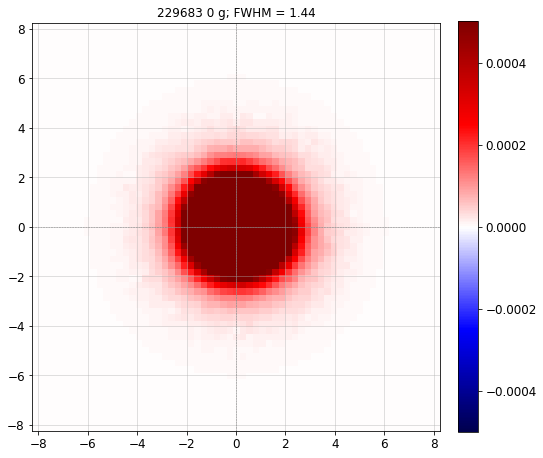

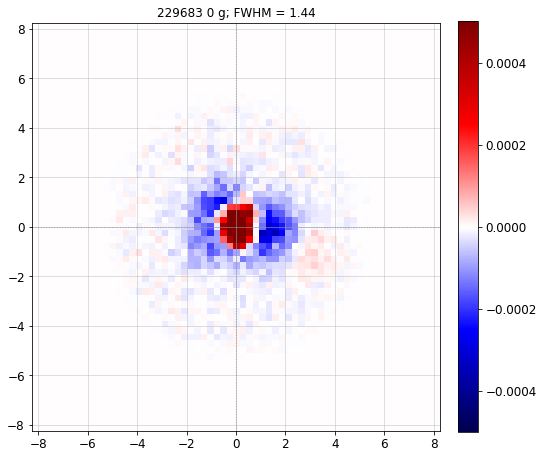

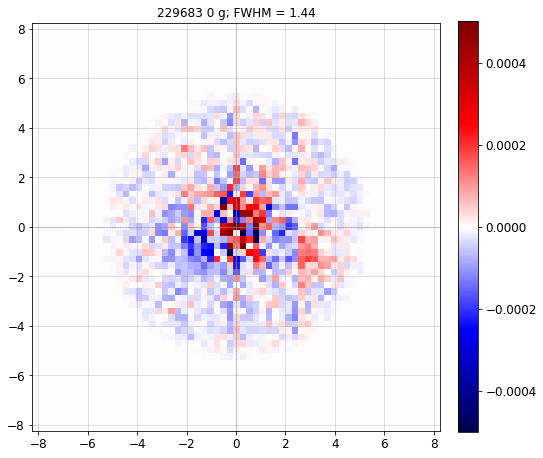

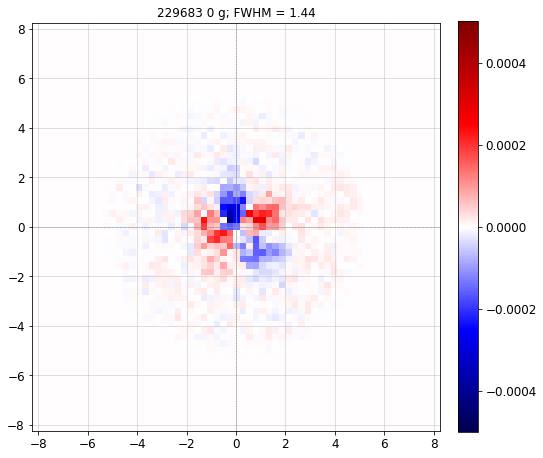

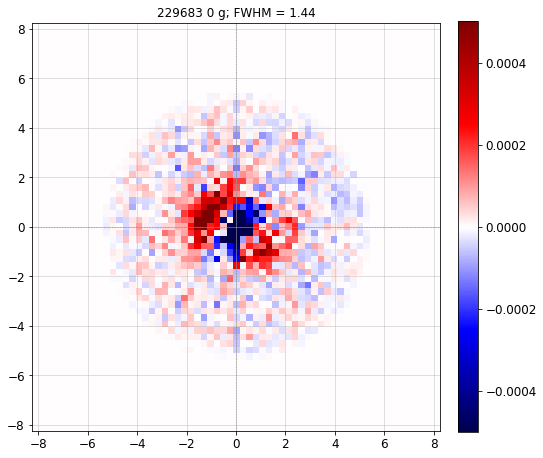

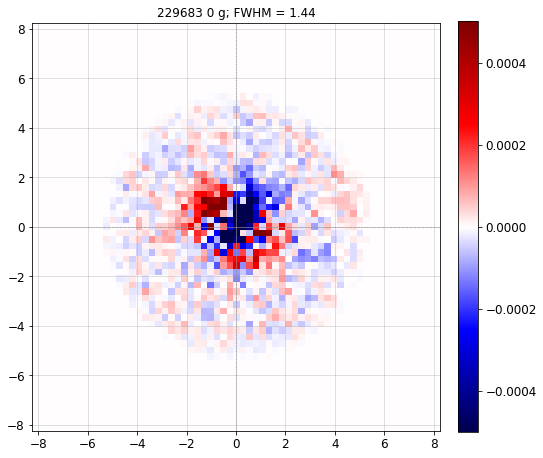

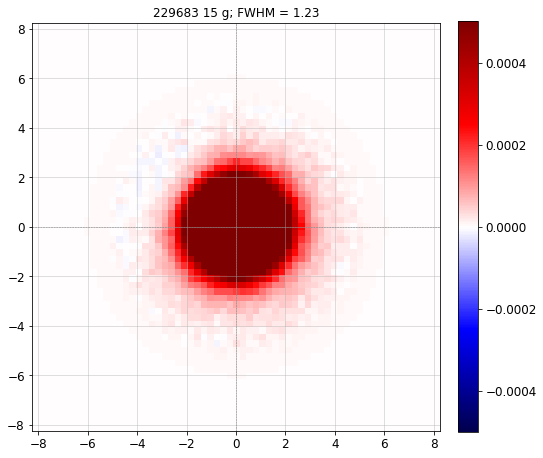

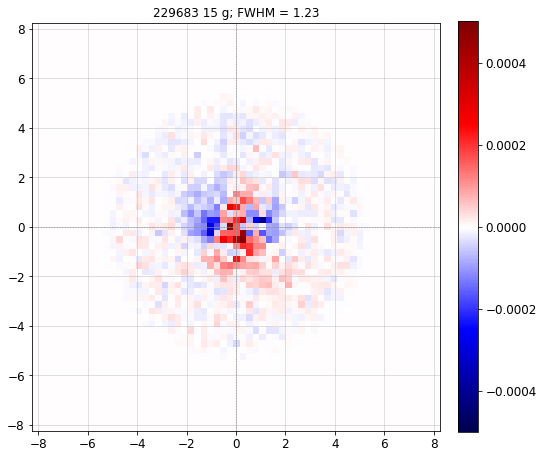

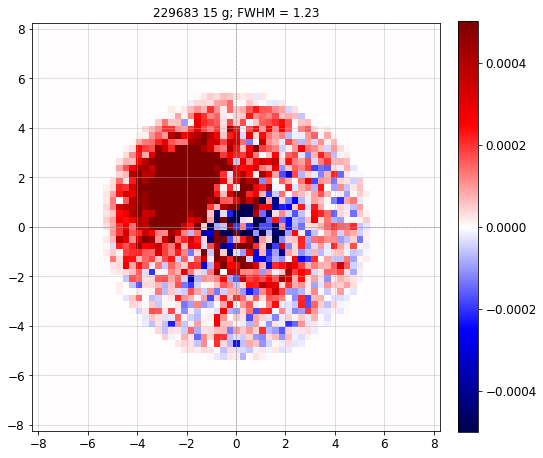

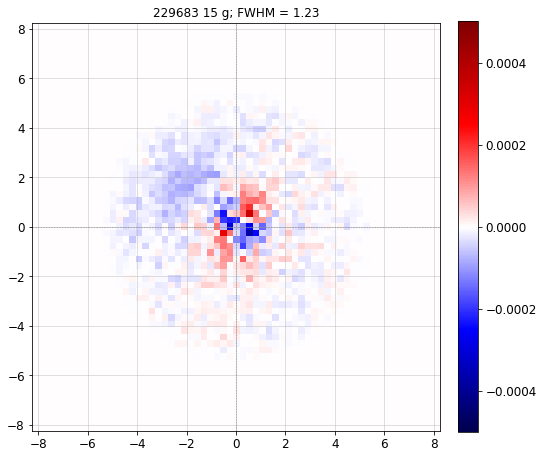

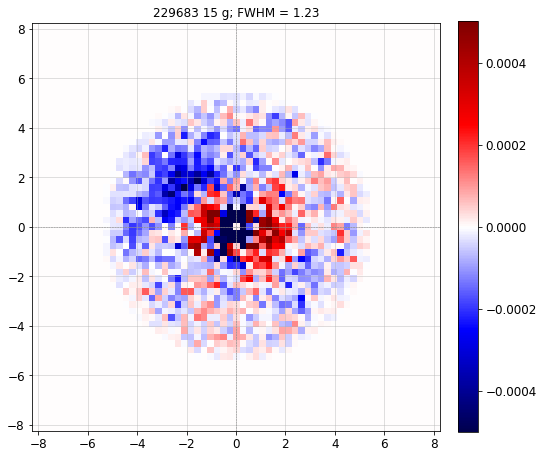

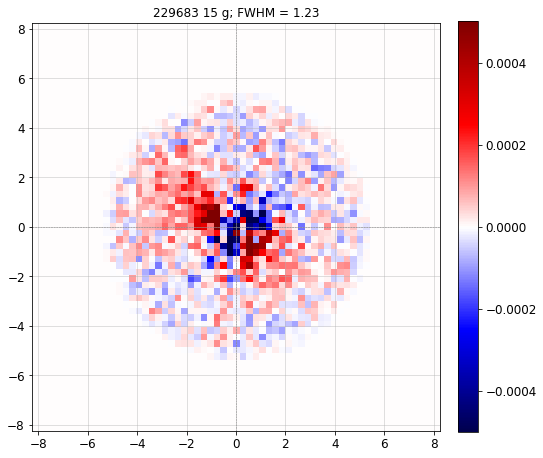

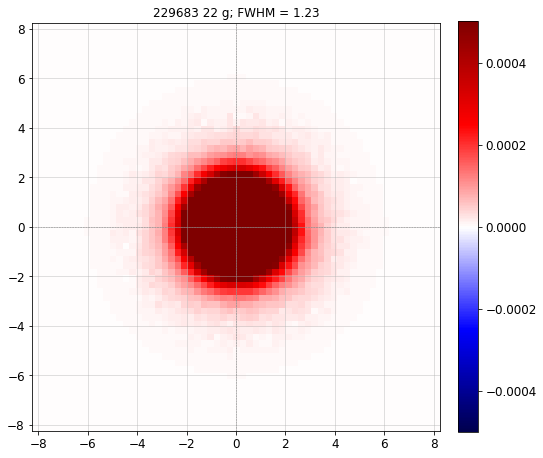

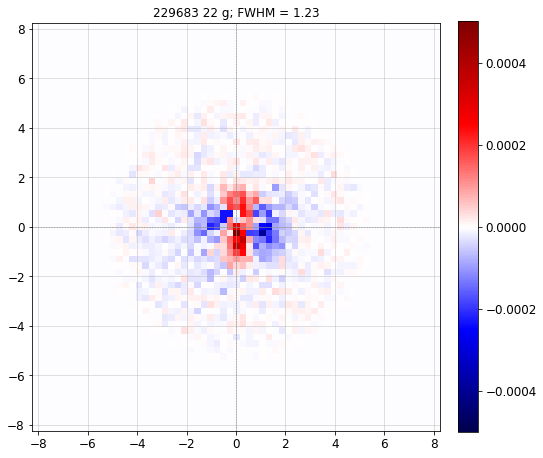

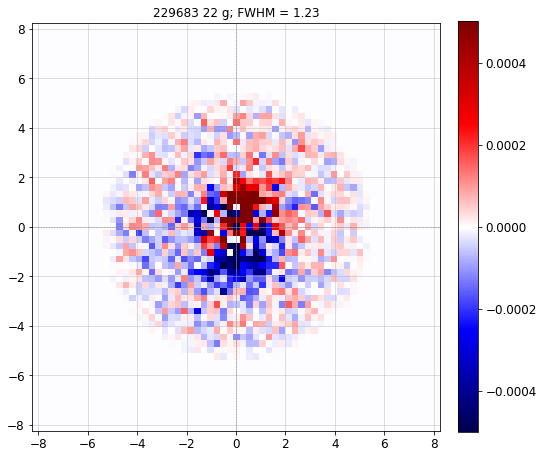

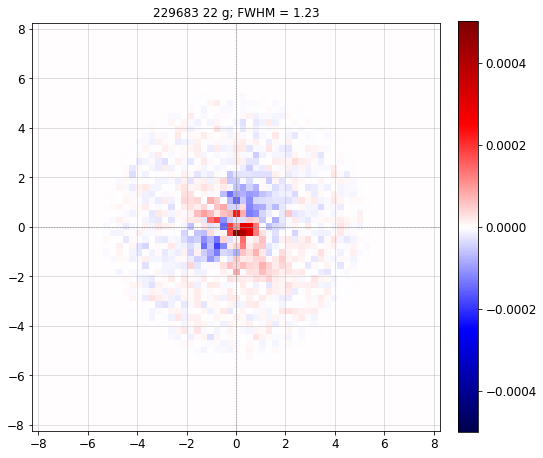

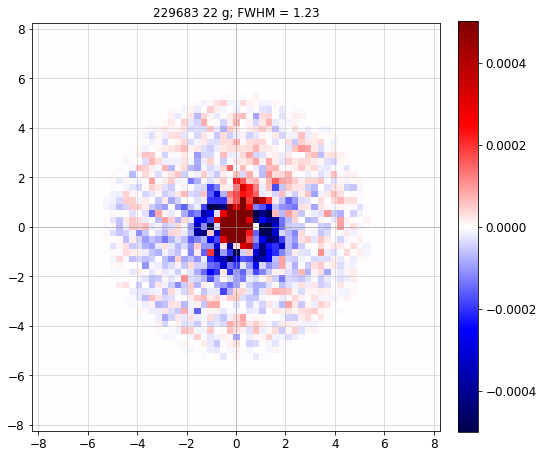

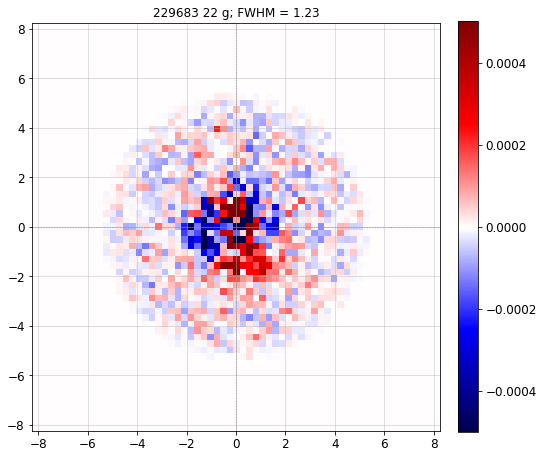

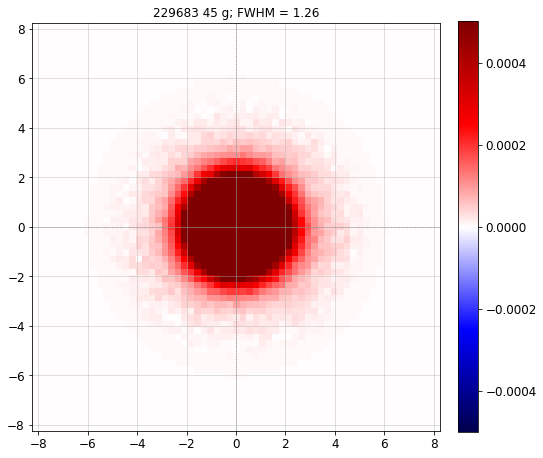

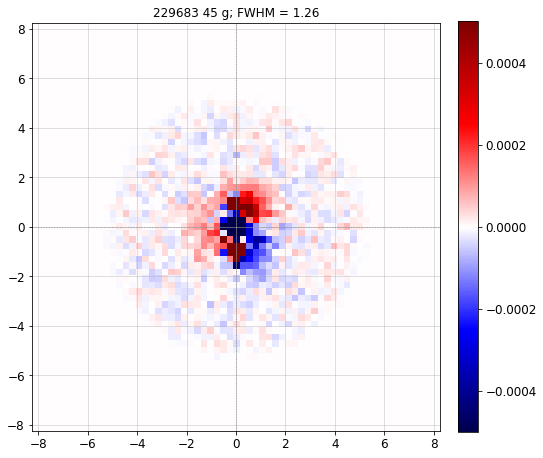

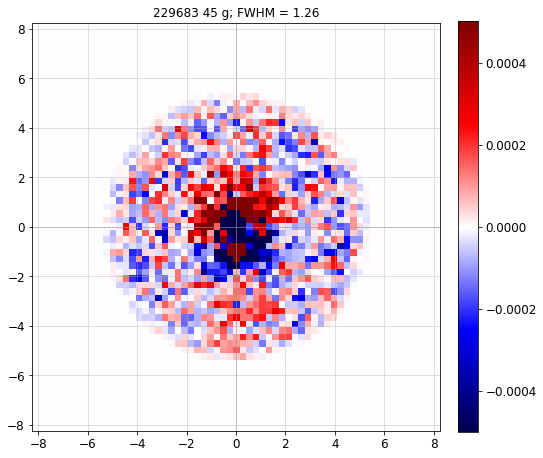

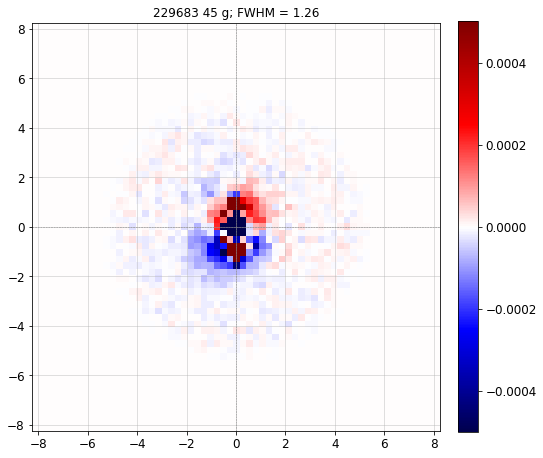

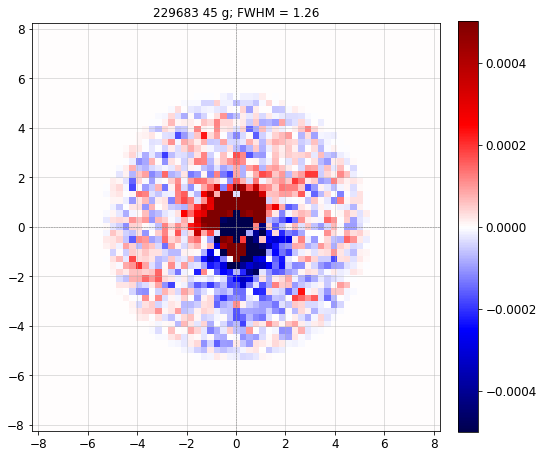

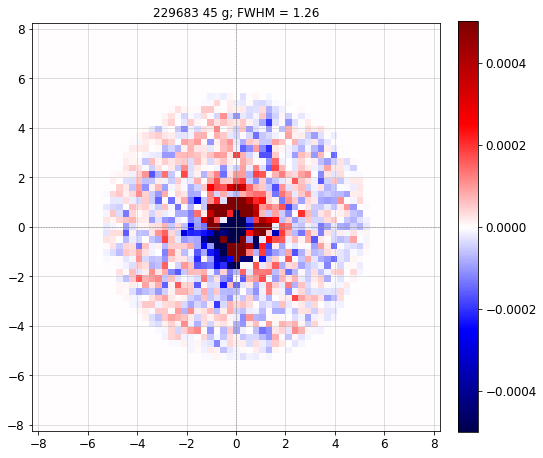

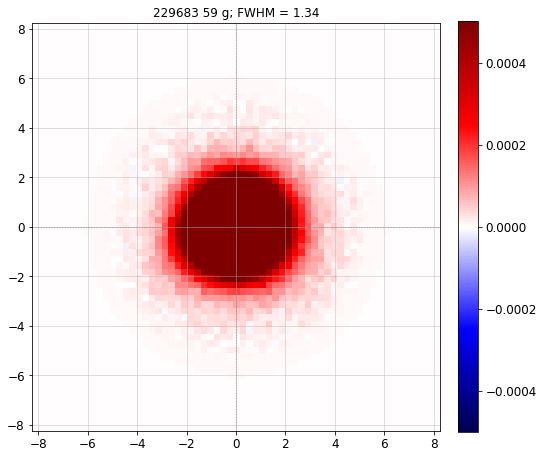

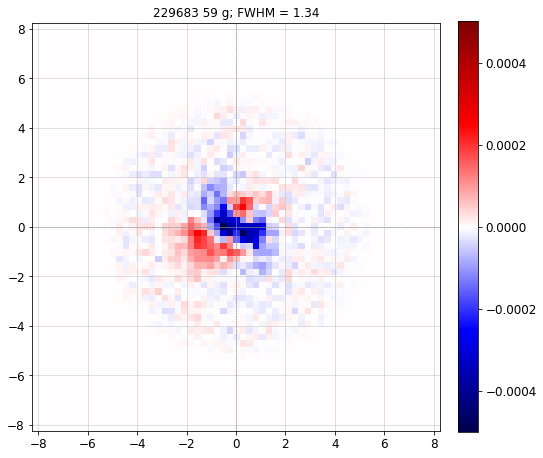

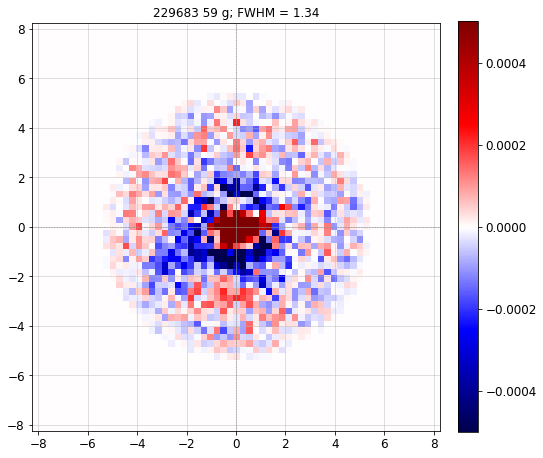

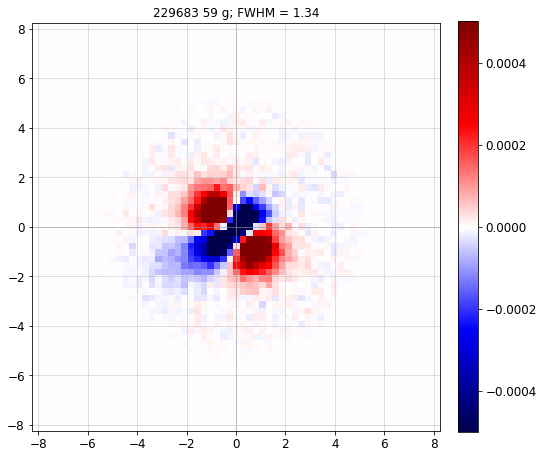

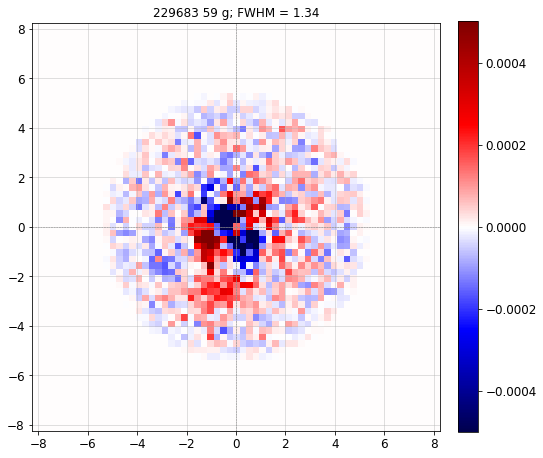

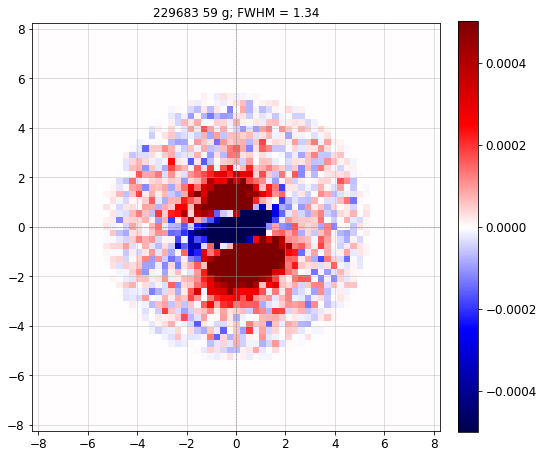

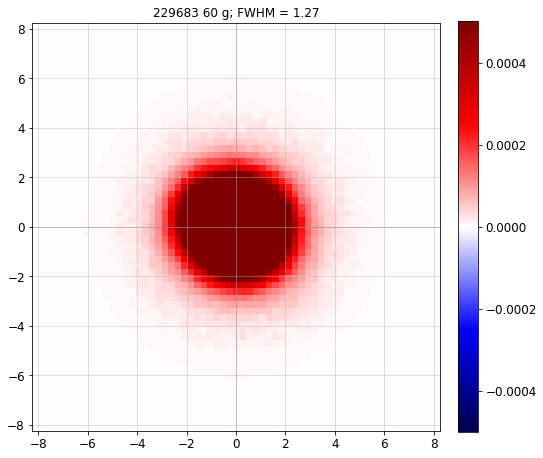

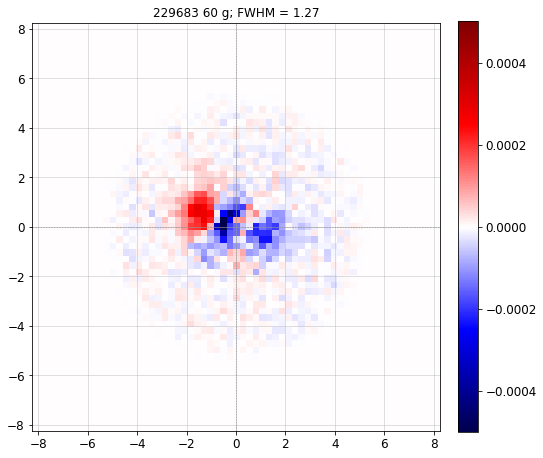

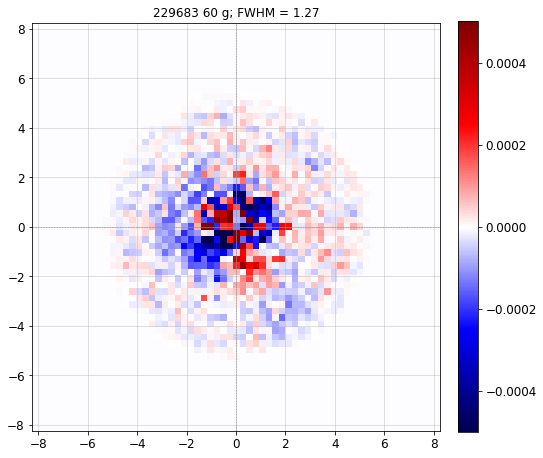

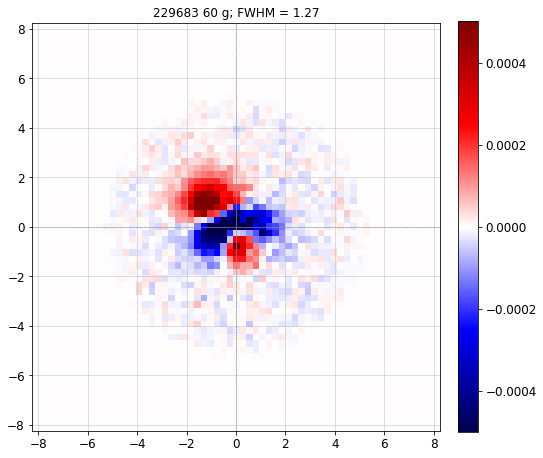

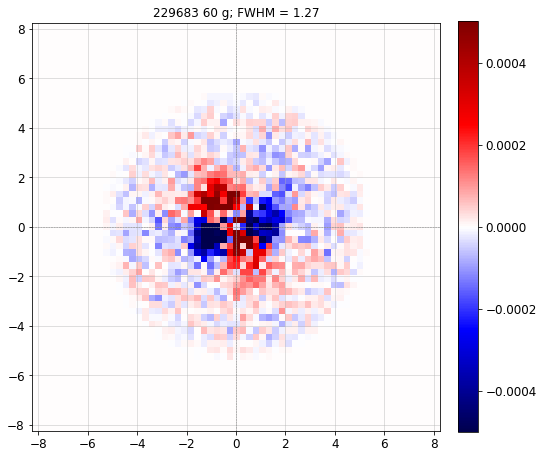

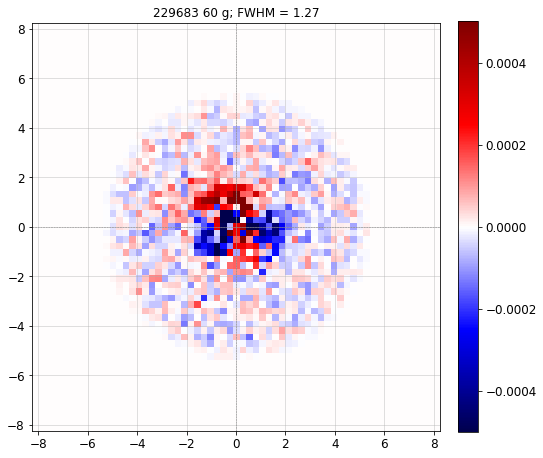

In [96]:
vrange = 0.0005

# for index, expnum in enumerate(expnum_all):
for index, expnum in enumerate(expnum_all[:1]):
    
    expnum_str = str(expnum)

    fn = os.path.join(output_dir, '{}/decam-{}.fits'.format((5-len(expnum_str[:3]))*'0'+expnum_str[:3], (8-len(expnum_str))*'0'+expnum_str))
    
    hdu = fits.open(fn)
    psf_mask = hdu[1].data['psf_mask']
    # print(psf_mask.shape)

    # for ccd_index in range(len(psf_mask)):
    for ccd_index in[0, 15, 22, 45, 59, 60]:
        
        psf_all = psf_mask[ccd_index]
        # print(psf_all.shape)

        # psf_index = 0
        for psf_index in range(len(psf_all)):
            
            psfi = psf_all[psf_index]
            plot_cutout(psfi, pixscale_native, vmin=-vrange, vmax=vrange)
            plt.title('{} {} {}; FWHM = {:.2f}'.format(expnum, ccd_index, band, pixscale_native*ccd['fwhm'][ccd_index]))
            plt.show()